## **Importing files and libraries**

### Libraries

In [1]:
# For Data
import os
#import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from datetime import datetime
from scipy import  fftpack
#from re import split
import emd
from scipy import ndimage
import statistics

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ARResults
from arch import arch_model



import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from mpl_toolkits.mplot3d import axes3d

# Distributions
#from scipy import stats
#import inspect
#from statsmodels.distributions.empirical_distribution import ECDF

# matplotlib Settings
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# warnings Settings
import warnings
warnings.filterwarnings('ignore')


#Others
from IPython.display import Image
#import numpy as np
#import scipy.fftpack as fourier
#import matplotlib.pyplot as plt
#import scipy.io.wavfile as waves

### Files

#### Load

In [2]:
# Verificar el directorio actual
print("Directorio actual:", os.getcwd())

# Cambiar al directorio superior (bajar un nivel)
os.chdir('../..')

# Verificar el nuevo directorio
print("Nuevo directorio actual:", os.getcwd())

Directorio actual: d:\lenovo\Documents\GitHub\Energy-and-linear-momentum-change-exerted-by-the-solar-wind-for-applications-in-electric-solar-sails\Codes\Past
Nuevo directorio actual: d:\lenovo\Documents\GitHub\Energy-and-linear-momentum-change-exerted-by-the-solar-wind-for-applications-in-electric-solar-sails


In [20]:
#Function for simply the files load
def dir(r_or_p, year=2000, extension="txt"):
    rp = ("Raw", "Calibrated", "Electron")
    r_or_p = r_or_p.strip().capitalize()
    if r_or_p not in rp: #Validate data
        raise NameError("Only Raw, Processed o Electron")

    if r_or_p == rp[0]:
      dir = f"Data/2000/Raw/{year}.{extension}"
      return dir
    elif r_or_p == rp[1]:
      dir = f"Data/2000/Calibrated/{year}.{extension}"
      return dir
    else:
      dir = f"Data/2000/Electron/{year}.{extension}"

      return dir



In [4]:
#Years that have a analysis
i_year = 1998
f_year = 2023
step_year = 5
other_year = 2000

years = [year for year in range(i_year, f_year + step_year, step_year)] #+ [other_year]
years = [2000]
years.sort()

years

[2000]

#### Raw data

In [5]:
head_row = ["YY","MON", "DY","DOY:HH:MM:SS","SPEED","Np", "Vth","N/S","V_He", "GSE_X","GSE_Y","GSE_Z","RANGE","HGLAT","HGLONG","CRN(E)"]

skip = [ i for i in range(0, 26, 1)]

Raw_data = {}
for year in years:
  Raw_data[year] = pd.read_csv(dir("Raw",year), skiprows=skip, sep="\s+", header=[1])
  Raw_data[year].columns = head_row

display(Raw_data[2000])

,YY,MON,DY,DOY:HH:MM:SS,SPEED,Np,Vth,N/S,V_He,GSE_X,GSE_Y,GSE_Z,RANGE,HGLAT,HGLONG,CRN(E)
0,0,Jan,1,001:00:00:10,667,4.76,62,1.4,713,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
1,0,Jan,1,001:00:00:40,673,4.57,63,1.2,721,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
2,0,Jan,1,001:00:01:10,673,4.59,63,1.2,721,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
3,0,Jan,1,001:00:01:40,667,4.76,62,1.6,712,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
4,0,Jan,1,001:00:02:10,668,5.16,60,1.3,711,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033323,0,Dec,31,366:23:57:16,280,6.53,17,0.3,281,201.0,-85.7,7.2,145.8,-3.0,217.6,1971
1033324,0,Dec,31,366:23:57:46,279,6.37,17,0.1,279,201.0,-85.7,7.2,145.8,-3.0,217.6,1971
1033325,0,Dec,31,366:23:58:20,275,6.15,17,0.3,276,201.0,-85.7,7.2,145.8,-3.0,217.6,1971
1033326,0,Dec,31,366:23:58:50,278,6.39,17,0.6,279,201.0,-85.7,7.2,145.8,-3.0,217.6,1971


#### Processed/ Calibrated data

In [6]:
head_row = ["YY","MON", "DY","DOY:HH:MM:SS","SPEED","Np", "Vth","N/S","V_He", "GSE_X","GSE_Y","GSE_Z","RANGE","HGLAT","HGLONG","CRN(E)"]



# Palabras clave que identifican encabezados no deseados
keywords = ['InSitu_Start__Time', '[km/s]', '[cm-3]', '[deg]', '[Re]', '[Mkm]', '[#]',
            'YY', 'MON', 'DY', 'DOY:HH:MM:SS', 'SPEED', 'Np', 'Vth', 'N/S', 'V_He',
            'GSE_X', 'GSE_Y', 'GSE_Z', 'RANGE', 'HGLAT', 'HGLONG', 'CRN(E)']




Calibrated_data = {}
for year in years:
  filtered_data = []
  with open(dir("Calibrated",year), 'r') as file:
      for line in file:
          if not any(keyword in line for keyword in keywords):
              filtered_data.append(line.strip().split())

  Calibrated_data[year] = pd.DataFrame(filtered_data)#pd.read_csv(dir("Calibrated",year), sep="\s+", header=None)
  #Calibrated_data[year] = Calibrated_data[year][pd.to_numeric(Calibrated_data[year]['DOY:HH:MM:SS'], errors='coerce').notna()]
  
  Calibrated_data[year].columns = head_row

display(Calibrated_data[2000])

,YY,MON,DY,DOY:HH:MM:SS,SPEED,Np,Vth,N/S,V_He,GSE_X,GSE_Y,GSE_Z,RANGE,HGLAT,HGLONG,CRN(E)
0,00,Jan,01,001:00:00:10,669,4.69,62,1.6,715,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
1,00,Jan,01,001:00:05:10,677,4.69,63,0.6,725,210.1,-101.2,0.8,145.8,-3.0,8.2,1957
2,00,Jan,01,001:00:10:13,689,4.10,63,-0.1,738,210.1,-101.2,0.8,145.8,-3.0,8.2,1957
3,00,Jan,01,001:00:15:15,692,3.74,64,-1.2,742,210.1,-101.2,0.8,145.8,-3.0,8.1,1957
4,00,Jan,01,001:00:20:16,689,3.78,63,-1.2,738,210.1,-101.2,0.8,145.8,-3.0,8.1,1957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103615,00,Dec,31,366:23:36:08,282,7.56,17,0.7,282,201.0,-85.7,7.2,145.8,-3.1,217.7,1971
103616,00,Dec,31,366:23:41:10,284,7.06,17,0.7,285,201.0,-85.7,7.2,145.8,-3.1,217.7,1971
103617,00,Dec,31,366:23:46:13,289,6.84,17,1.0,289,201.0,-85.7,7.2,145.8,-3.1,217.6,1971
103618,00,Dec,31,366:23:51:15,290,7.04,18,1.2,291,201.0,-85.7,7.2,145.8,-3.1,217.6,1971


#### Electron data

In [7]:
head_row = ["YY", "MON", "DY", "DOY:HH:MM:SS", "Te", "Ee", "Ve", "Ne", "GSE_X", "GSE_Y", "GSE_Z"]


Electron_data = {}
for year in years:

    # Leer todas las líneas del archivo
    with open(dir("Electron",year), 'r') as file:
        lines = file.readlines()

    # Filtrar las últimas tres líneas específicas
    filtered_data = lines[:-3]  # Excluir las últimas tres líneas

    # Convertir las líneas filtradas a un DataFrame si es necesario
    # Por ejemplo, si las columnas están separadas por espacios:
    Electron_data[year] = pd.DataFrame([line.strip().split(',') for line in filtered_data if line.strip() and not line.startswith('#')])

    # Nombrar las columnas usando la primera fila si corresponde
    Electron_data[year].columns = Electron_data[year].iloc[0]  # Usa la primera fila como nombres de columna
    Electron_data[year] = Electron_data[year][1:]  # Elimina la fila de nombres de columna si ya se usó
    Electron_data[year] = Electron_data[year].reset_index(drop=True)

    #Electron_data[year] = pd.read_csv(dir("Electron",year))
    #Electron_data[year].columns = ["TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ","TE_Deg_K","E_AVG_eV","UE_MAGNITUDE_km/s","ELECTRON_DENSITY_/cc","SC_X_GSE_Earth_Radii","SC_Y_GSE_Earth_Radii","SC_Z_GSE_Earth_Radii"]

    Electron_data[year]['TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(
        Electron_data[year]['TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ'], 
        format='%Y-%m-%dT%H:%M:%S.%fZ', 
        errors='coerce'
    )

    Electron_data[year] = Electron_data[year].dropna(subset=['TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ'])

    Electron_data[year]['YY'] = Electron_data[year]['TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ'].dt.year
    Electron_data[year]['MON'] = Electron_data[year]['TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ'].dt.month
    Electron_data[year]['DY'] = Electron_data[year]['TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ'].dt.day
    Electron_data[year]['DOY:HH:MM:SS'] = Electron_data[year]['TIME_(UT)_yyyy-mm-ddThh:mm:ss.sssZ'].dt.strftime('%j:%H:%M:%S')

    Electron_data[year] = Electron_data[year].rename(columns={
        'TE_Deg_K': 'Te', 
        'E_AVG_eV': 'Ee', 
        'UE_MAGNITUDE_km/s': 'Ve', 
        'ELECTRON_DENSITY_/cc': 'Ne', 
        'SC_X_GSE_Earth_Radii': 'GSE_X', 
        'SC_Y_GSE_Earth_Radii': 'GSE_Y', 
        'SC_Z_GSE_Earth_Radii': 'GSE_Z'
    })
    Electron_data[year]["YY"].replace(2000, 0, inplace=True)

    month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
    Electron_data[year]['MON'] = Electron_data[year]['MON'].map(month_map)

    Electron_data[year] = Electron_data[year][head_row]

display(Electron_data[2000])


,YY,MON,DY,DOY:HH:MM:SS,Te,Ee,Ve,Ne,GSE_X,GSE_Y,GSE_Z
0,0,Jan,10,010:00:00:01,210038.,27.1843,448.112,2.49883,-65.0671,-31.2366,9.50173
1,0,Jan,10,010:00:00:22,183082.,23.6955,384.879,2.57068,-65.0671,-31.2366,9.50173
2,0,Jan,10,010:00:00:35,196294.,25.4054,484.973,2.39350,-65.0671,-31.2366,9.50173
3,0,Jan,10,010:00:00:47,176764.,22.8778,337.147,2.54951,-65.0671,-31.2366,9.50173
4,0,Jan,10,010:00:00:59,184589.,23.8905,319.365,2.55491,-65.0671,-31.2366,9.50173
...,...,...,...,...,...,...,...,...,...,...,...
1920764,0,Dec,31,366:23:58:57,144155.,18.6574,307.338,6.38586,4.89613,251.067,-17.2631
1920765,0,Dec,31,366:23:59:06,146943.,19.0183,336.372,6.52617,4.89613,251.067,-17.2631
1920766,0,Dec,31,366:23:59:28,143444.,18.5654,326.583,6.13768,4.89613,251.067,-17.2631
1920767,0,Dec,31,366:23:59:40,141783.,18.3504,368.666,6.19805,4.89613,251.067,-17.2631


## Time

In [8]:
#### Time
def sec(yy, doy_hh_mm_ss, initial): #Function for obtain total seconds
    # Convert string to datetime format
    datofeo = ["0", "3", "8"]
    if str(yy) not in datofeo:
      date = datetime.strptime(str(yy) +":" + str(doy_hh_mm_ss), '%y:%j:%H:%M:%S')
    else:
      date = datetime.strptime("0" + str(yy) +":" + str(doy_hh_mm_ss), '%y:%j:%H:%M:%S')

    # Calculate the difference from the reference datetime
    timedelta = date - datetime(1900, 1, 1)

    # Total seconds
    seconds = timedelta.total_seconds() -3155673610.0#- 3092601600 # - 98 years and 24 days

    return seconds #Return float of the total seconds


import re

def valid_time_format(time_string):
    pattern = r"^\d{3}:\d{2}:\d{2}:\d{2}$"  # Adjust to expected 'DOY:HH:MM:SS' format
    return bool(re.match(pattern, time_string))

def Seconds_data(data, initial):
    time_sec = data['DOY:HH:MM:SS'] # Rename time col for simplicity
    year = data["YY"]
    
    seconds_time = [
        sec(year[i], time_sec[i], initial) if valid_time_format(time_sec[i]) else None
        for i in range(len(time_sec))
    ]# Obtain each total seconds in all dataframe
    data.insert(4, "Seconds", seconds_time) # Insert total seconds to dataframe

In [9]:
Secondszeroraw = 0
Secondszerocalibrated = 0
Secondszeroelectron = 0
for year in years:
  Seconds_data(Raw_data[year], Secondszeroraw)
  Seconds_data(Calibrated_data[year], Secondszerocalibrated)
  Seconds_data(Electron_data[year], Secondszeroelectron)
  
  Secondszeroraw += Raw_data[year]["Seconds"][len(Raw_data[year])-1]
  Secondszerocalibrated += Calibrated_data[year]["Seconds"][len(Calibrated_data[year])-1]
  Secondszeroelectron += Electron_data[year]["Seconds"][len(Electron_data[year])-1]


In [10]:
"""
for year in years:
  #Calibrated_data[year].to_csv(f'Data\Processing_converter\{year}.csv')
  #Raw_data[year].to_csv(f'Data\Raw_converter\{year}.csv')
  Calibrated_data[year].to_parquet(f'Data/2000/Calibrated/{year}.parquet', compression='gzip')
  Raw_data[year].to_parquet(f'Data/2000/Raw/{year}.parquet', compression='gzip')
  Electron_data[year].to_parquet(f'Data/2000/Electron\{year}.parquet', compression='gzip')
  #h = pd.read_csv("2023.csv")
  #h.drop(columns = ["Unnamed: 0"])


  display(Calibrated_data[year])
  display(Raw_data[year])
  display(Electron_data[year])
  """

'\nfor year in years:\n  #Calibrated_data[year].to_csv(f\'Data\\Processing_converter\\{year}.csv\')\n  #Raw_data[year].to_csv(f\'Data\\Raw_converter\\{year}.csv\')\n  Calibrated_data[year].to_parquet(f\'Data/2000/Calibrated/{year}.parquet\', compression=\'gzip\')\n  Raw_data[year].to_parquet(f\'Data/2000/Raw/{year}.parquet\', compression=\'gzip\')\n  Electron_data[year].to_parquet(f\'Data/2000/Electron\\{year}.parquet\', compression=\'gzip\')\n  #h = pd.read_csv("2023.csv")\n  #h.drop(columns = ["Unnamed: 0"])\n\n\n  display(Calibrated_data[year])\n  display(Raw_data[year])\n  display(Electron_data[year])\n  '

In [11]:
np.min([Calibrated_data[year]["Seconds"][0], Raw_data[year]["Seconds"][0], Electron_data[year]["Seconds"][0]])

0.0

In [12]:
print(Calibrated_data[year].columns)
print(Raw_data[year].columns)
print(Electron_data[year].columns)

Index(['YY', 'MON', 'DY', 'DOY:HH:MM:SS', 'Seconds', 'SPEED', 'Np', 'Vth',
       'N/S', 'V_He', 'GSE_X', 'GSE_Y', 'GSE_Z', 'RANGE', 'HGLAT', 'HGLONG',
       'CRN(E)'],
      dtype='object')
Index(['YY', 'MON', 'DY', 'DOY:HH:MM:SS', 'Seconds', 'SPEED', 'Np', 'Vth',
       'N/S', 'V_He', 'GSE_X', 'GSE_Y', 'GSE_Z', 'RANGE', 'HGLAT', 'HGLONG',
       'CRN(E)'],
      dtype='object')
Index(['YY', 'MON', 'DY', 'DOY:HH:MM:SS', 'Seconds', 'Te', 'Ee', 'Ve', 'Ne',
       'GSE_X', 'GSE_Y', 'GSE_Z'],
      dtype='object', name=0)


In [13]:
data = [Raw_data[year], Calibrated_data[year], Electron_data[year]]
names = ["Raw", "Calibrated", "Electron"]
colors = ["blue", "green", "red"]

Proton = ['SPEED', 'Np', 'Vth', 'N/S', 'V_He']
Electron = ['Te', 'Ee', 'Ve', 'Ne']

In [ ]:
for year in years:
  for df in data:
    # Convertir todas las columnas a float, excepto "YY", "MM", "SS"
    columns_to_convert = [col for col in df.columns if col not in ['YY', 'MON', 'DY', 'DOY:HH:MM:SS']]

    dirp = [col for col in columns_to_convert if col not in ['N/S', 'GSE_X', 'GSE_Y', 'GSE_Z', 'RANGE', 'HGLAT', 'HGLONG', 'CRN(E)']]
    
    for column_to_convert in columns_to_convert:
        df[column_to_convert] = pd.to_numeric(df[column_to_convert], errors='coerce')

    for column in dirp:
       df[column] = df[column].abs()
       #df[column] = df[column].apply(lambda x: (abs(x) + 0) / 2 if x < 0 else x)  

    # Reemplazar None por NaN
    #Raw_data[year] = Raw_data[year].applymap(lambda x: np.nan if x is None else x)
    #Calibrated_data[year] = Calibrated_data[year].applymap(lambda x: np.nan if x is None else x)
    #Electron_data[year] = Electron_data[year].applymap(lambda x: np.nan if x is None else x)


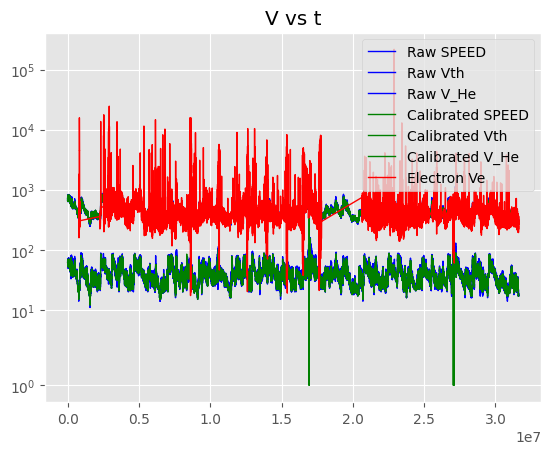

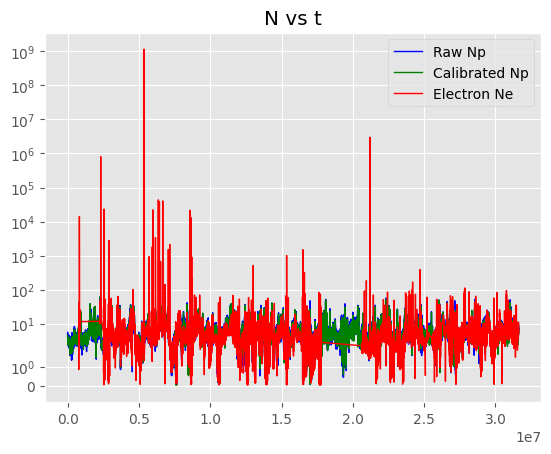

In [15]:
plt.figure()
plt.plot(data[0]["Seconds"], data[0]['SPEED'], label=f'{names[0]} SPEED', c=colors[0], linewidth=1)
plt.plot(data[0]["Seconds"], data[0]['Vth'], label=f'{names[0]} Vth', c=colors[0], linewidth=1)
plt.plot(data[0]["Seconds"], data[0]['V_He'], label=f'{names[0]} V_He', c=colors[0], linewidth=1)
plt.plot(data[1]["Seconds"], data[1]['SPEED'], label=f'{names[1]} SPEED', c=colors[1], linewidth=1)
plt.plot(data[1]["Seconds"], data[1]['Vth'], label=f'{names[1]} Vth', c=colors[1], linewidth=1)
plt.plot(data[1]["Seconds"], data[1]['V_He'], label=f'{names[1]} V_He', c=colors[1], linewidth=1)
plt.plot(data[2]["Seconds"], data[2]['Ve'], label=f'{names[2]} Ve', c=colors[2], linewidth=1)
plt.legend()
plt.yscale("symlog")
plt.title("V vs t")
plt.show()


plt.figure()
plt.plot(data[0]["Seconds"], data[0]['Np'], label=f'{names[0]} Np', c=colors[0], linewidth=1)
plt.plot(data[1]["Seconds"], data[1]['Np'], label=f'{names[1]} Np', c=colors[1], linewidth=1)
plt.plot(data[2]["Seconds"], data[2]['Ne'], label=f'{names[2]} Ne', c=colors[2], linewidth=1)
plt.legend()
plt.title("N vs t")
plt.yscale("symlog")
plt.show()

In [16]:
"""
for df, name, color in zip(data, names, colors):
    if name != names[2]:
        for i in Proton:
            #df[i] = df[i].abs()
            plt.plot(df["Seconds"], abs(df[i]), label=name, c="Darkblue", linewidth=1)
            plt.legend()
            plt.title(i)
            plt.yscale("symlog")
            plt.show()
    else:
        for i in Electron:
            #df[i] = df[i].abs()
            plt.plot(df["Seconds"], np.abs(df[i]), label=name, c="Darkblue", linewidth=1)
            plt.legend()
            plt.title(i)
            plt.yscale("symlog")
            plt.show()
"""

'\nfor df, name, color in zip(data, names, colors):\n    if name != names[2]:\n        for i in Proton:\n            #df[i] = df[i].abs()\n            plt.plot(df["Seconds"], abs(df[i]), label=name, c="Darkblue", linewidth=1)\n            plt.legend()\n            plt.title(i)\n            plt.yscale("symlog")\n            plt.show()\n    else:\n        for i in Electron:\n            #df[i] = df[i].abs()\n            plt.plot(df["Seconds"], np.abs(df[i]), label=name, c="Darkblue", linewidth=1)\n            plt.legend()\n            plt.title(i)\n            plt.yscale("symlog")\n            plt.show()\n'

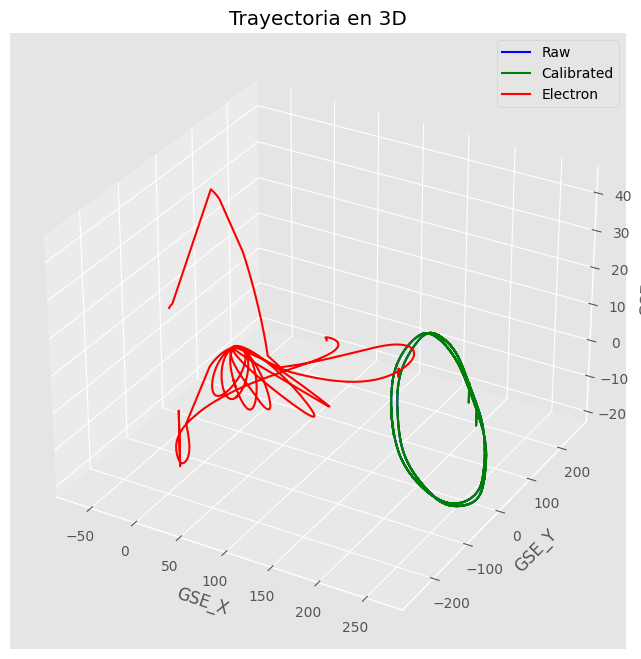

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for df, name, color in zip(data, names, colors):
    # Convertir las columnas a valores numéricos, reemplazando errores con NaN
    #df['GSE_X'] = pd.to_numeric(df['GSE_X'], errors='coerce')
    #df['GSE_Y'] = pd.to_numeric(df['GSE_Y'], errors='coerce')
    #df['GSE_Z'] = pd.to_numeric(df['GSE_Z'], errors='coerce')
    
    # Eliminar filas con valores NaN en las columnas GSE_X, GSE_Y, o GSE_Z
    #df_clean = df.dropna(subset=['GSE_X', 'GSE_Y', 'GSE_Z'])
    
    # Graficar los datos en 3D
    ax.plot(xs=df['GSE_X'], ys=df['GSE_Y'], zs=df['GSE_Z'], color=color, label=name)

# Etiquetas y título
ax.set_xlabel('GSE_X')
ax.set_ylabel('GSE_Y')
ax.set_zlabel('GSE_Z')
ax.set_title('Trayectoria en 3D')
ax.legend()

plt.show()



## Create .parquet files


In [22]:
for year in years:
    display(Calibrated_data[year])
    display(Raw_data[year])
    display(Electron_data[year])

,YY,MON,DY,DOY:HH:MM:SS,Seconds,SPEED,Np,Vth,N/S,V_He,GSE_X,GSE_Y,GSE_Z,RANGE,HGLAT,HGLONG,CRN(E)
0,00,Jan,01,001:00:00:10,0.0,669,4.69,62,1.6,715,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
1,00,Jan,01,001:00:05:10,300.0,677,4.69,63,0.6,725,210.1,-101.2,0.8,145.8,-3.0,8.2,1957
2,00,Jan,01,001:00:10:13,603.0,689,4.10,63,-0.1,738,210.1,-101.2,0.8,145.8,-3.0,8.2,1957
3,00,Jan,01,001:00:15:15,905.0,692,3.74,64,-1.2,742,210.1,-101.2,0.8,145.8,-3.0,8.1,1957
4,00,Jan,01,001:00:20:16,1206.0,689,3.78,63,-1.2,738,210.1,-101.2,0.8,145.8,-3.0,8.1,1957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103615,00,Dec,31,366:23:36:08,31620958.0,282,7.56,17,0.7,282,201.0,-85.7,7.2,145.8,-3.1,217.7,1971
103616,00,Dec,31,366:23:41:10,31621260.0,284,7.06,17,0.7,285,201.0,-85.7,7.2,145.8,-3.1,217.7,1971
103617,00,Dec,31,366:23:46:13,31621563.0,289,6.84,17,1.0,289,201.0,-85.7,7.2,145.8,-3.1,217.6,1971
103618,00,Dec,31,366:23:51:15,31621865.0,290,7.04,18,1.2,291,201.0,-85.7,7.2,145.8,-3.1,217.6,1971


,YY,MON,DY,DOY:HH:MM:SS,Seconds,SPEED,Np,Vth,N/S,V_He,GSE_X,GSE_Y,GSE_Z,RANGE,HGLAT,HGLONG,CRN(E)
0,0,Jan,1,001:00:00:10,0.0,667,4.76,62,1.4,713,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
1,0,Jan,1,001:00:00:40,30.0,673,4.57,63,1.2,721,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
2,0,Jan,1,001:00:01:10,60.0,673,4.59,63,1.2,721,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
3,0,Jan,1,001:00:01:40,90.0,667,4.76,62,1.6,712,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
4,0,Jan,1,001:00:02:10,120.0,668,5.16,60,1.3,711,210.1,-101.2,0.8,145.8,-3.0,8.3,1957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033323,0,Dec,31,366:23:57:16,31622226.0,280,6.53,17,0.3,281,201.0,-85.7,7.2,145.8,-3.0,217.6,1971
1033324,0,Dec,31,366:23:57:46,31622256.0,279,6.37,17,0.1,279,201.0,-85.7,7.2,145.8,-3.0,217.6,1971
1033325,0,Dec,31,366:23:58:20,31622290.0,275,6.15,17,0.3,276,201.0,-85.7,7.2,145.8,-3.0,217.6,1971
1033326,0,Dec,31,366:23:58:50,31622320.0,278,6.39,17,0.6,279,201.0,-85.7,7.2,145.8,-3.0,217.6,1971


,YY,MON,DY,DOY:HH:MM:SS,Seconds,Te,Ee,Ve,Ne,GSE_X,GSE_Y,GSE_Z
0,0,Jan,10,010:00:00:01,777591.0,210038.0,27.1843,448.112,2.49883,-65.06710,-31.2366,9.50173
1,0,Jan,10,010:00:00:22,777612.0,183082.0,23.6955,384.879,2.57068,-65.06710,-31.2366,9.50173
2,0,Jan,10,010:00:00:35,777625.0,196294.0,25.4054,484.973,2.39350,-65.06710,-31.2366,9.50173
3,0,Jan,10,010:00:00:47,777637.0,176764.0,22.8778,337.147,2.54951,-65.06710,-31.2366,9.50173
4,0,Jan,10,010:00:00:59,777649.0,184589.0,23.8905,319.365,2.55491,-65.06710,-31.2366,9.50173
...,...,...,...,...,...,...,...,...,...,...,...,...
1920764,0,Dec,31,366:23:58:57,31622327.0,144155.0,18.6574,307.338,6.38586,4.89613,251.0670,-17.26310
1920765,0,Dec,31,366:23:59:06,31622336.0,146943.0,19.0183,336.372,6.52617,4.89613,251.0670,-17.26310
1920766,0,Dec,31,366:23:59:28,31622358.0,143444.0,18.5654,326.583,6.13768,4.89613,251.0670,-17.26310
1920767,0,Dec,31,366:23:59:40,31622370.0,141783.0,18.3504,368.666,6.19805,4.89613,251.0670,-17.26310


In [21]:
for year in years:
  #Calibrated_data[year].to_csv(f'Data\Processing_converter\{year}.csv')
  #Raw_data[year].to_csv(f'Data\Raw_converter\{year}.csv')
  Calibrated_data[year].to_parquet(dir("Calibrated",year,"parquet"), compression='gzip')
  Raw_data[year].to_parquet(dir("Raw",year,"parquet"), compression='gzip')
  Electron_data[year].to_parquet(dir("Electron",year,"parquet"), compression='gzip')
  #h = pd.read_csv("2023.csv")
  #h.drop(columns = ["Unnamed: 0"])